In [58]:
import os
import math
import random
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Tuple, List, Optional
from pre_process_data import PreProcessData
from datasets import CTPatchDataset

In [59]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
import shutil

In [60]:
# Since dataset and labels are already split between Experiment 1 and Experiment 2
# Maybe we just use Experiment 1 as our training data, and Experiment 2 as our testing data?
# Later we can change it (maybe combine them and do a random split/shuffle?)

@dataclass
class Config:
	project_root = Path.cwd() if (Path.cwd() / "data").exists() else Path.cwd().parent	# Paths to experiments
	exp1_path = project_root / "data" / "Experiment 1 - Blind"
	exp2_path = project_root / "data" / "Experiment 2 - Open"

	# Each row contains (uuid, slice, x, y)
	exp1_labels_csv = project_root / "data" / "labels_exp1.csv"
	exp2_labels_csv = project_root / "data" / "labels_exp2.csv"

	# Contains folders: <uuid>/volume.npz
	export_root = project_root / "processed_dataset"
	combined_csv = project_root / "processed_dataset" / "combined_labels.csv"

	# So we don't hardcode "volume" everywhere
	volume_key = "volume"

	# Patch/Window around (x, y) from labels csv to feed into CNN
	patch_size = 128

	# Randomly shift crop center by this many pixels during training
	jitter_px = 6

	# Master switch for augmentations (jitter, flips, etc.)
	augment = True

	# Seed to keep random consistency
	seed = 6767

	# Training Parameters
	batch_size = 16
	epochs = 150
	lr = 0.001
	weight_decay = 0.0001
	device = "cuda" if torch.cuda.is_available() else "cpu"

	# If classes are very imbalanced, sampler helps.
	use_weighted_sampler = True

CFG = Config()

In [61]:
# Seed our stuff
random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed_all(CFG.seed)

In [62]:
print("Preprocessing data...\n")

# if the export root already exists and isn’t empty, assume the
# experiments have been processed and skip the work
if CFG.export_root.exists() and any(CFG.export_root.iterdir()):
	print(f"{CFG.export_root} already contains processed data; skipping preprocessing.")
else:
	# make sure the export root is there before we try to write into it
	if not CFG.export_root.exists():
		print(f"{CFG.export_root} does not exist – creating it.")
		CFG.export_root.mkdir(parents=True, exist_ok=True)

	# Process Experiment 1 - Blind into the shared export root
	print(f"Processing {CFG.exp1_path} into {CFG.export_root}...")
	PreProcessData(CFG.exp1_path, CFG.export_root).run()
	print(f"{CFG.exp1_path} processed!\n")

	# Process Experiment 2 - Open into the same export root
	print(f"Processing {CFG.exp2_path} into {CFG.export_root}...")
	PreProcessData(CFG.exp2_path, CFG.export_root).run()
	print(f"{CFG.exp2_path} processed!\n")

	# Code to merge CFG.exp1_labels_csv and CFG.exp2_labels_csv into one CSV of uuid and labels,
	# checking that each one uuid folder exists inside CFG.export_root and exporting into CFG.combined_csv Path.
	print("Merging label CSVs...")

	# load the two label files
	df1 = pd.read_csv(CFG.exp1_labels_csv)
	df2 = pd.read_csv(CFG.exp2_labels_csv)

	def _check_dirs(df: pd.DataFrame, name: str) -> set:
		uuids = set(df['uuid'].astype(str))
		missing = [u for u in uuids if not (CFG.export_root / u).exists()]
		if missing:
			print(f"{name}: {len(missing)} uuids missing from {CFG.export_root} – first few: {missing[:5]}")
		return uuids

	exp1_uuids = _check_dirs(df1, "exp1")
	exp2_uuids = _check_dirs(df2, "exp2")

	dups = exp1_uuids & exp2_uuids
	if dups:
		print(f"duplicate uuids present in both experiments: {sorted(dups)}")

	combined_df = pd.concat([df1, df2], ignore_index=True)
	combined_df = combined_df.drop_duplicates()

	# make sure the directory for the combined csv exists
	CFG.combined_csv.parent.mkdir(parents=True, exist_ok=True)
	combined_df.to_csv(CFG.combined_csv, index=False)
	print(f"wrote {len(combined_df)} rows of labels to {CFG.combined_csv}")

print("Preprocessing finished!")

Preprocessing data...

/Users/ningkaiyang/Desktop/CS 172B Project/processed_dataset does not exist – creating it.
Processing /Users/ningkaiyang/Desktop/CS 172B Project/data/Experiment 1 - Blind into /Users/ningkaiyang/Desktop/CS 172B Project/processed_dataset...
/Users/ningkaiyang/Desktop/CS 172B Project/data/Experiment 1 - Blind processed!

Processing /Users/ningkaiyang/Desktop/CS 172B Project/data/Experiment 2 - Open into /Users/ningkaiyang/Desktop/CS 172B Project/processed_dataset...
/Users/ningkaiyang/Desktop/CS 172B Project/data/Experiment 2 - Open processed!

Merging label CSVs...
duplicate uuids present in both experiments: ['6031', '7507']
wrote 163 rows of labels to /Users/ningkaiyang/Desktop/CS 172B Project/processed_dataset/combined_labels.csv
Preprocessing finished!


In [63]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Assuming patch_size=128 then
        # Input (B, 1, 128, 128)

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1), # Output (B, 16, 128, 128)
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output (B, 16, 64, 64)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1), # Output (B, 32, 64, 64)
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output (B, 32, 32, 32)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # Output (B, 64, 32, 32)
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )

        self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1)) # Output (B, 64, 1, 1) then must flatten to (B, 64)
        self.fc1 = nn.Linear(in_features=64, out_features=4) # Output (B, 4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, 1, 128, 128)
        x = self.block1(x)         # (B, 16, 64, 64)
        x = self.block2(x)         # (B, 32, 32, 32)
        x = self.block3(x)         # (B, 64, 32, 32)
        x = self.gap(x)            # (B, 64, 1, 1)
        x = torch.flatten(x, 1)    # (B, 64)
        x = self.fc1(x)            # (B, 4)
        
        return x    

In [64]:
# Sanity Check
model = CNN()
dummy = torch.randn(16, 1, 128, 128)
out = model(dummy)
print(out.shape) # Should print dimensions (16, 4)

torch.Size([16, 4])


In [65]:
# Create Datasets
# For now well train on Experiment 1 and test on Experiment 1
train_ds = CTPatchDataset(CFG.exp1_export_root, CFG.exp1_labels_csv, CFG.patch_size, CFG.augment, CFG.jitter_px)
test_ds = CTPatchDataset(CFG.exp2_export_root, CFG.exp2_labels_csv, CFG.patch_size, CFG.augment, CFG.jitter_px)

# Santiy check CTPatchDataset
x, y = train_ds[0]
print(x.shape, x.dtype, y, y.dtype) # Should output (1, patch_size, patch_size), torch.float32, tensor(0), and torch.int64

AttributeError: 'Config' object has no attribute 'exp1_export_root'

In [ ]:
# Create DataLoaders
# For now well train on Experiment 1 and test on Experiment 1
train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=CFG.batch_size, shuffle=False, num_workers=0)

# Sanity check DataLoader
xb, yb = next(iter(train_loader))
print(xb.shape, xb.dtype, yb.shape, yb.dtype) # Should output(16, 1, patch_size, patch_size), torch.float32, (16,), and torch.int64

torch.Size([16, 1, 128, 128]) torch.float32 torch.Size([16]) torch.int64


In [ ]:
# Initialize our model
model = CNN()
model.to(CFG.device)

# 4 classes, use CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# NOTE: Hypertune optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)

In [ ]:
# Train our model
# this shits cooked bruh (expected tho)
logged_epochs = list()
losses = list()
validation_acc = list()
for epoch in range(CFG.epochs):
    model.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(CFG.device)        # (B,1,128,128)
        yb = yb.to(CFG.device)        # (B,)

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)        # (B,4)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(CFG.device)
            yb = yb.to(CFG.device)
            logits = model(xb)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.numel()

    val_acc = correct / total
    if (epoch+1)%(CFG.epochs/25) == 0:
        print(f"epoch={epoch+1} train_loss={train_loss:.4f} val_acc={val_acc:.3f}")
        logged_epochs.append(epoch+1)
        losses.append(train_loss)
        validation_acc.append(val_acc)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ningkaiyang/Desktop/CS 172B Project/src/data/export_exp2/7507/volume.npz'

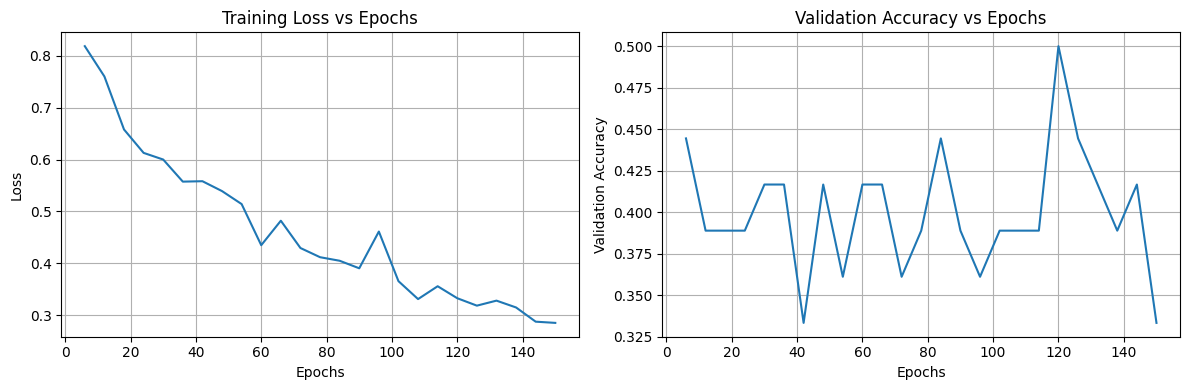

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(logged_epochs, losses)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss vs Epochs')
ax1.grid(True)

ax2.plot(logged_epochs, validation_acc)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Accuracy')
ax2.set_title('Validation Accuracy vs Epochs')
ax2.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# this overfitting hella ngl
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(CFG.device)
        yb = yb.to(CFG.device)
        logits = model(xb)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.numel()

val_acc = correct / total
print(f"Accuracy on Test Dataset: {val_acc:.4f}")

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in train_loader:
        xb = xb.to(CFG.device)
        yb = yb.to(CFG.device)
        logits = model(xb)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.numel()

val_acc = correct / total
print(f"Accuracy on Train Dataset: {val_acc:.4f}")

Accuracy on Test Dataset: 0.3889
Accuracy on Train Dataset: 0.8195
